### XGBoost

In [1]:
%matplotlib inline
from utils import *
import xgboost as xgb
from time import time

Using Theano backend.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
act_train_data = pd.read_csv("./act_train.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8}, 
                             parse_dates=['date'])
act_test_data  = pd.read_csv("./act_test.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str}, parse_dates=['date'])
people_data    = pd.read_csv("./people.csv", 
                             dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32}, 
                             parse_dates=['date'])

In [3]:
act_train_data[:3]

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [4]:
act_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
people_id            object
activity_id          object
date                 datetime64[ns]
activity_category    object
char_1               object
char_2               object
char_3               object
char_4               object
char_5               object
char_6               object
char_7               object
char_8               object
char_9               object
char_10              object
outcome              int8
dtypes: datetime64[ns](1), int8(1), object(13)
memory usage: 236.8+ MB


In [5]:
people_data[:3]

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99


In [6]:
people_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
people_id    189118 non-null object
char_1       189118 non-null object
group_1      189118 non-null object
char_2       189118 non-null object
date         189118 non-null datetime64[ns]
char_3       189118 non-null object
char_4       189118 non-null object
char_5       189118 non-null object
char_6       189118 non-null object
char_7       189118 non-null object
char_8       189118 non-null object
char_9       189118 non-null object
char_10      189118 non-null bool
char_11      189118 non-null bool
char_12      189118 non-null bool
char_13      189118 non-null bool
char_14      189118 non-null bool
char_15      189118 non-null bool
char_16      189118 non-null bool
char_17      189118 non-null bool
char_18      189118 non-null bool
char_19      189118 non-null bool
char_20      189118 non-null bool
char_21      189118 non-null bool
char_22      189118 non-null bool
char_23

In [7]:
print("Train data shape: " + format(act_train_data.shape))
print("Test data shape: " + format(act_test_data.shape))
print("People data shape: " + format(people_data.shape))

Train data shape: (2197291, 15)
Test data shape: (498687, 14)
People data shape: (189118, 41)


In [3]:
def reduce_dim(dataset, column):
    # summarize those showing only once to one category
    for index, dup in dataset[column].duplicated(keep=False).iteritems():
        if dup == False:
            dataset.set_value(index, column, -1)
    # re-index
    new_index = {idx:i for i, idx in enumerate(dataset[column].unique())}
    dataset[column] = dataset[column].apply(lambda x: new_index[x])
    return dataset
    
def act_data_treatment(dsname):
    dataset = dsname
    
    for col in list(dataset.columns):
        if col not in ['people_id', 'activity_id', 'date', 'char_38', 'outcome']:
            if dataset[col].dtype == 'object':
                # regard NA as a category
                dataset[col].fillna('type 0', inplace=True)
                dataset[col] = dataset[col].apply(lambda x: x.split(' ')[1]).astype(np.int32)
            elif dataset[col].dtype == 'bool':
                # change binary feature to type int (0/1)
                dataset[col] = dataset[col].astype(np.int8)
    
    dataset['year'] = dataset['date'].dt.year
    dataset['month'] = dataset['date'].dt.month
    dataset['day'] = dataset['date'].dt.day
    dataset['isweekend'] = (dataset['date'].dt.weekday >= 5).astype('int8')
    dataset = dataset.drop('date', axis=1)
    
    return dataset

In [4]:
act_train_data = act_train_data.drop('char_10', axis=1)
act_test_data = act_test_data.drop('char_10', axis=1)

print("Train data shape: " + format(act_train_data.shape))
print("Test data shape: " + format(act_test_data.shape))
print("People data shape: " + format(people_data.shape))

Train data shape: (2197291, 14)
Test data shape: (498687, 13)
People data shape: (189118, 41)


In [5]:
act_train_data = act_data_treatment(act_train_data)
act_test_data  = act_data_treatment(act_test_data)
people_data    = act_data_treatment(people_data)

In [6]:
train = act_train_data.merge(people_data, on='people_id', how='left')
test  = act_test_data.merge(people_data, on='people_id', how='left')
act_id = act_test_data['activity_id']

del act_train_data, act_test_data, people_data

In [12]:
print("Train data shape: " + format(train.shape))
print("Test data shape: " + format(test.shape))

Train data shape: (2197291, 61)
Test data shape: (498687, 60)


In [7]:
{col:len(train[col].unique()) for col in train.columns}

{'activity_category': 7,
 'activity_id': 2197291,
 'char_10': 2,
 'char_11': 2,
 'char_12': 2,
 'char_13': 2,
 'char_14': 2,
 'char_15': 2,
 'char_16': 2,
 'char_17': 2,
 'char_18': 2,
 'char_19': 2,
 'char_1_x': 52,
 'char_1_y': 2,
 'char_20': 2,
 'char_21': 2,
 'char_22': 2,
 'char_23': 2,
 'char_24': 2,
 'char_25': 2,
 'char_26': 2,
 'char_27': 2,
 'char_28': 2,
 'char_29': 2,
 'char_2_x': 33,
 'char_2_y': 3,
 'char_30': 2,
 'char_31': 2,
 'char_32': 2,
 'char_33': 2,
 'char_34': 2,
 'char_35': 2,
 'char_36': 2,
 'char_37': 2,
 'char_38': 101,
 'char_3_x': 12,
 'char_3_y': 43,
 'char_4_x': 8,
 'char_4_y': 25,
 'char_5_x': 8,
 'char_5_y': 9,
 'char_6_x': 6,
 'char_6_y': 7,
 'char_7_x': 9,
 'char_7_y': 25,
 'char_8_x': 19,
 'char_8_y': 8,
 'char_9_x': 20,
 'char_9_y': 9,
 'day_x': 31,
 'day_y': 31,
 'group_1': 29899,
 'isweekend_x': 2,
 'isweekend_y': 2,
 'month_x': 12,
 'month_y': 12,
 'outcome': 2,
 'people_id': 151295,
 'year_x': 2,
 'year_y': 4}

In [9]:
whole = pd.concat([train, test], ignore_index=True)
categorical = ['group_1', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 
               'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y',
               'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y']
t0 = time()
for category in categorical:
    whole = reduce_dim(whole, category)
print "Elapsed time %.2f seconds for cleaning categorical features." %(time()-t0)

X = whole[:(len(train))]
X_test = whole[len(train):]

np.random.seed(0)
mask = np.random.rand(len(train)) < 0.2
X_val, X = X[mask], X[~mask]
y_val, y = train['outcome'][mask], train['outcome'][~mask]

del whole
print("Train data shape: " + format(X.shape))
print("Validation data shape: " + format(X_val.shape))
print("Test data shape: " + format(X_test.shape))

not_categorical = list(set(X.columns)-set(categorical)-{'activity_id','people_id','outcome'})

Elapsed time 98.99 seconds for cleaning categorical features.
Train data shape: (1757500, 60)
Validation data shape: (439791, 60)
Test data shape: (498687, 60)


In [10]:
X_test = X_test.drop('outcome', axis=1)
X['outcome'].mean()

0.44402731152204838

### Linear function based

In [27]:
from sklearn.preprocessing import OneHotEncoder

print "One-hot encoding and transforming to sparse..."
t0 = time()
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X[categorical], X_val[categorical], X_test[categorical]]))
X_cat_sparse = enc.transform(X[categorical])
X_val_cat_sparse = enc.transform(X_val[categorical])
X_test_cat_sparse = enc.transform(X_test[categorical])

from scipy.sparse import hstack
X_sparse = hstack((X[not_categorical], X_cat_sparse))
X_val_sparse = hstack((X_val[not_categorical], X_val_cat_sparse))
X_test_sparse = hstack((X_test[not_categorical], X_test_cat_sparse))
print "Elapsed time: %.2f seconds." %(time()-t0)

print("Training data: " + format(X_sparse.shape))
print("Validating data: " + format(X_val_sparse.shape))
print("Test data: " + format(X_test_sparse.shape))
del X, X_val, X_test, X_cat_sparse, X_val_cat_sparse, X_test_cat_sparse

One-hot encoding and transforming to sparse...
Elapsed time: 37.33 seconds.
Training data: (1757500, 31271)
Validating data: (439791, 31271)
Test data: (498687, 31271)


In [28]:
%%time
print "XGBoost initialing..."
dtest = xgb.DMatrix(X_test_sparse)
dtrain = xgb.DMatrix(X_sparse, label=y)
dval = xgb.DMatrix(X_val_sparse, label=y_val)

XGBoost initialing...
CPU times: user 1min 13s, sys: 22.8 s, total: 1min 36s
Wall time: 1min 43s


In [15]:
class AucCall(object):
    def __init__(self, lr_decay):
        self.train_auc = []
        self.valid_auc = []
        self.lr_decay = lr_decay
        self.best_val_auc = 0.0
    def __call__(self, env):
        # Record the evaluation and Save the best model
        tr_auc = dict(env.evaluation_result_list)['train-auc']
        self.train_auc.append(tr_auc)
        val_auc = dict(env.evaluation_result_list)['validation-auc']
        self.valid_auc.append(val_auc)
        if val_auc > self.best_val_auc:
            print "The BEST val_auc until now. Saving model..."
            self.best_val_auc = val_auc
            env.model.save_model('./best_redhat.model')
        new_lr_rate = self.rateDecay(env.iteration)
        env.model.set_param('eta', new_lr_rate)
    def rateDecay(self, iter_round):
        # Set learning rate decay
        return param['eta'] / (1 + self.lr_decay * iter_round)

In [32]:
param = {'nthread':4, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc', 'booster':'gblinear', 
         'eta':0.2, 'alpha': 0., 'lambda':0.2, 'seed':0}
watchlist  = [(dtrain,'train'), (dval,'validation')]
early_stopping_rounds = 5
num_round = 100

In [33]:
%%time
print("Start training...")
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)
# test auc: 0.9806

Start training...
[0]	train-auc:0.951647	validation-auc:0.951301
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 5 rounds.
[1]	train-auc:0.984079	validation-auc:0.983475
[2]	train-auc:0.991389	validation-auc:0.990851
[3]	train-auc:0.993853	validation-auc:0.993354
[4]	train-auc:0.995084	validation-auc:0.994607
[5]	train-auc:0.995794	validation-auc:0.995331
[6]	train-auc:0.996231	validation-auc:0.995778
[7]	train-auc:0.996512	validation-auc:0.996068
[8]	train-auc:0.996699	validation-auc:0.996265
[9]	train-auc:0.996821	validation-auc:0.996398
[10]	train-auc:0.996902	validation-auc:0.996489
[11]	train-auc:0.996958	validation-auc:0.996553
[12]	train-auc:0.996997	validation-auc:0.996597
[13]	train-auc:0.997025	validation-auc:0.996629
[14]	train-auc:0.997045	validation-auc:0.996652
[15]	train-auc:0.99706	validation-auc:0.996668
[16]	train-auc:0.997072	validation-auc:0.996681
[17]	train-auc:0.99708	va

In [34]:
pred = bst.predict(dtest)
submit = pd.DataFrame({ 'activity_id': act_id, 'outcome': pred })
submit.to_csv('eval_gbl_init.csv', index=False)

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

pred_val = bst.predict(dval)
val_score = roc_auc_score(y_val, pred_val)
fpr, tpr, thresholds = roc_curve(y_val, pred_val)

In [36]:
print('validation accuracy: %.4f%%' % (np.mean((pred_val>=0.5).astype(int) == y_val)*100))
print('validation auc score: %.4f' % val_score)

validation accuracy: 96.9583%
validation auc score: 0.9967


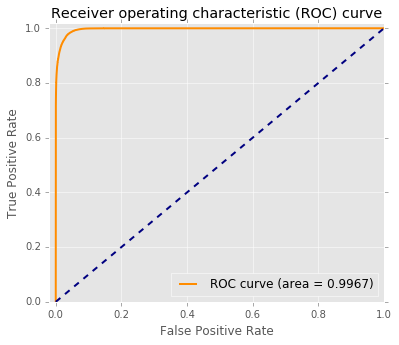

In [37]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.4f)' % val_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
#plt.axis('tight')
plt.show()

[[235997   8675]
 [  4702 190417]]


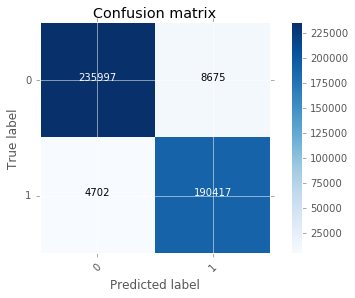

In [38]:
cm = confusion_matrix(y_val, (pred_val>=0.5).astype(int))
plot_confusion_matrix(cm, [0,1])

[[ 0.5366  0.0197]
 [ 0.0107  0.433 ]]


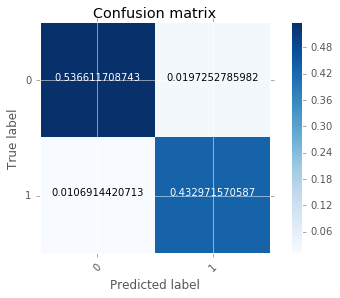

In [39]:
plot_confusion_matrix(cm / float(len(y_val)), [0,1])

### Tree-based

In [42]:
from sklearn.preprocessing import OneHotEncoder

print "One-hot encoding and transforming to sparse..."
t0 = time()
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(pd.concat([X[categorical], X_val[categorical], X_test[categorical]]))
X_cat_sparse = enc.transform(X[categorical])
X_val_cat_sparse = enc.transform(X_val[categorical])
X_test_cat_sparse = enc.transform(X_test[categorical])

from scipy.sparse import hstack
X_sparse = hstack((X[not_categorical], X_cat_sparse))
X_val_sparse = hstack((X_val[not_categorical], X_val_cat_sparse))
X_test_sparse = hstack((X_test[not_categorical], X_test_cat_sparse))
print "Elapsed time: %.2f seconds." %(time()-t0)

print("Training data: " + format(X_sparse.shape))
print("Validating data: " + format(X_val_sparse.shape))
print("Test data: " + format(X_test_sparse.shape))
del X, X_val, X_test, X_cat_sparse, X_val_cat_sparse, X_test_cat_sparse

One-hot encoding and transforming to sparse...
Elapsed time: 53.26 seconds.
Training data: (1757500, 31271)
Validating data: (439791, 31271)
Test data: (498687, 31271)


In [43]:
%%time
print "XGBoost initialing..."
dtest = xgb.DMatrix(X_test_sparse)
dtrain = xgb.DMatrix(X_sparse, label=y)
dval = xgb.DMatrix(X_val_sparse, label=y_val)

XGBoost initialing...
CPU times: user 1min 31s, sys: 27.1 s, total: 1min 58s
Wall time: 2min 9s


In [44]:
param = {'nthread':4, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc', 'booster':'gbtree', 
         'eta':0.2, 'max_depth': 8, 'subsample':0.8, 'colsample_bytree':0.5, 'seed':0}
watchlist  = [(dtrain,'train'), (dval,'validation')]
early_stopping_rounds = 10
num_round = 100

In [45]:
%%time
print("Start training...")
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)
# test auc: 0.9314

Start training...
[0]	train-auc:0.909172	validation-auc:0.909688
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 10 rounds.
[1]	train-auc:0.916019	validation-auc:0.916333
[2]	train-auc:0.918006	validation-auc:0.918399
[3]	train-auc:0.922536	validation-auc:0.922838
[4]	train-auc:0.927464	validation-auc:0.92781
[5]	train-auc:0.929506	validation-auc:0.929683
[6]	train-auc:0.931394	validation-auc:0.931545
[7]	train-auc:0.932208	validation-auc:0.932405
[8]	train-auc:0.932938	validation-auc:0.933067
[9]	train-auc:0.933364	validation-auc:0.933537
[10]	train-auc:0.935008	validation-auc:0.935107
[11]	train-auc:0.935613	validation-auc:0.935707
[12]	train-auc:0.936261	validation-auc:0.93644
[13]	train-auc:0.937856	validation-auc:0.938037
[14]	train-auc:0.938288	validation-auc:0.938451
[15]	train-auc:0.938813	validation-auc:0.938957
[16]	train-auc:0.939595	validation-auc:0.939732
[17]	train-auc:0.940145	v

In [46]:
pred = bst.predict(dtest)
submit = pd.DataFrame({ 'activity_id': act_id, 'outcome': pred })
submit.to_csv('eval_gbt_init.csv', index=False)

With no one-hot encoding

In [11]:
%%time
print "XGBoost initialing..."
dtest = xgb.DMatrix(X_test.drop(['activity_id', 'people_id'], axis=1))
dtrain = xgb.DMatrix(X.drop(['activity_id', 'people_id', 'outcome'], axis=1), label=y)
dval = xgb.DMatrix(X_val.drop(['activity_id', 'people_id', 'outcome'], axis=1), label=y_val)

XGBoost initialing...
CPU times: user 4.54 s, sys: 8.58 s, total: 13.1 s
Wall time: 16.3 s


In [21]:
param = {'nthread':4, 'silent':1, 'objective':'binary:logistic', 'eval_metric':'auc', 'booster':'gbtree', 
         'eta':0.2, 'max_depth': 8, 'subsample':0.8, 'colsample_bytree':0.5, 'seed':0}
watchlist  = [(dtrain,'train'), (dval,'validation')]
early_stopping_rounds = 10
num_round = 100

In [22]:
%%time
print("Start training...")
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds)
# test auc: 0.9539 

Start training...
[0]	train-auc:0.912029	validation-auc:0.912583
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 10 rounds.
[1]	train-auc:0.935972	validation-auc:0.936042
[2]	train-auc:0.940098	validation-auc:0.940098
[3]	train-auc:0.946023	validation-auc:0.946008
[4]	train-auc:0.946462	validation-auc:0.946469
[5]	train-auc:0.949036	validation-auc:0.949152
[6]	train-auc:0.949695	validation-auc:0.949836
[7]	train-auc:0.949954	validation-auc:0.950112
[8]	train-auc:0.952313	validation-auc:0.952345
[9]	train-auc:0.953944	validation-auc:0.954003
[10]	train-auc:0.954958	validation-auc:0.954976
[11]	train-auc:0.956255	validation-auc:0.956229
[12]	train-auc:0.957157	validation-auc:0.957093
[13]	train-auc:0.957602	validation-auc:0.957484
[14]	train-auc:0.958215	validation-auc:0.958074
[15]	train-auc:0.958682	validation-auc:0.958524
[16]	train-auc:0.958973	validation-auc:0.958797
[17]	train-auc:0.959996

In [19]:
pred = bst.predict(dtest)
submit = pd.DataFrame({ 'activity_id': act_id, 'outcome': pred })
submit.to_csv('eval_gbt_init.csv', index=False)

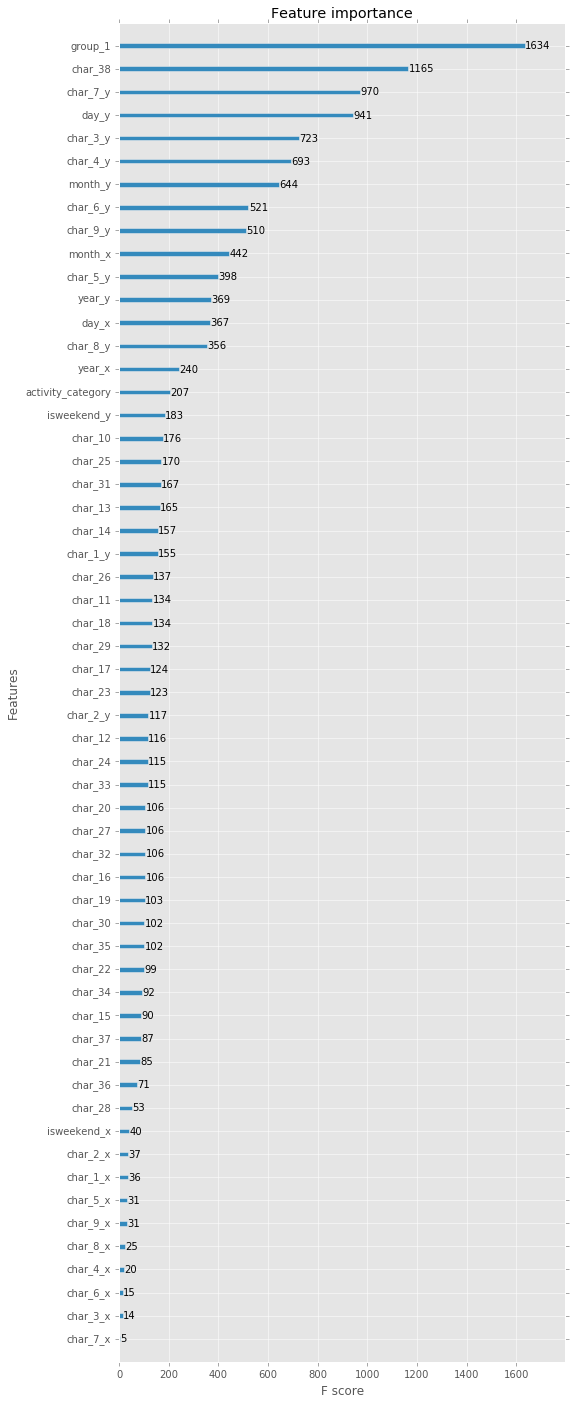

In [32]:
plt.style.use('ggplot')
from xgboost import plot_importance

fig, fscore_ax = plt.subplots(figsize=(8,24))
plot_importance(bst, ax=fscore_ax)